In [ ]:
%env KERAS_BACKEND=tensorflow

### Import需要的套件

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Activation, Lambda, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras import metrics
from keras.utils import np_utils

from keras import backend as K

import keras
from keras.backend import set_session
import tensorflow as tf
import os
def create_session(gpu_id='0', pp_mem_frac=None):

    tf.reset_default_graph()
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id # can multiple?
    with tf.device('/gpu:' + gpu_id):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        if pp_mem_frac is not None:
            config.gpu_options.per_process_gpu_memory_fraction=pp_mem_frac
        session = tf.Session(config = config)
    return session

gpu_id = '0'
sess = create_session(gpu_id)
set_session(sess)

Using TensorFlow backend.


### 準備使用的資料 MNIST Dataset及前處理

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("有 %d筆Training data,大少是 %d x %d" %x_train0.shape)
print("有 %d筆Testing data,大少是 %d x %d" %x_test0.shape)

有 60000筆Training data,大少是 28 x 28
有 10000筆Testing data,大少是 28 x 28


In [5]:
# reshape該資料
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)
#Normalization
x_train -= x_train.min()
x_train = x_train/x_train.max()

### VAE 的初始準備

In [6]:
enc_1 = Dense(100, activation='sigmoid')
enc_mean = Dense(2)  #Mean  
enc_log_var = Dense(2)  #Variance 

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [7]:
#把NN連起來
x = Input(shape=(784,))

enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [8]:
#抽樣函數的部分
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
x_hat = dec_1(dec_2(z))
VAE = Model(x, x_hat)

### 看看建立好的VAE模型

In [11]:
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

###  Loss 函數的建立

In [12]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

### 開始訓練 VAE

In [13]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [14]:
VAE.fit(x_train, x_train, batch_size=32, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 8s 135us/step - loss: 196.0781
Epoch 2/100
60000/60000 [==============================] - 8s 128us/step - loss: 181.0746
Epoch 3/100
60000/60000 [==============================] - 7s 120us/step - loss: 179.2766
Epoch 4/100
60000/60000 [==============================] - 7s 109us/step - loss: 177.1111
Epoch 5/100
60000/60000 [==============================] - 7s 109us/step - loss: 174.2552
Epoch 6/100
60000/60000 [==============================] - 6s 108us/step - loss: 170.9843
Epoch 7/100
60000/60000 [==============================] - 6s 108us/step - loss: 167.6701
Epoch 8/100
60000/60000 [==============================] - 7s 120us/step - loss: 165.0240
Epoch 9/100
60000/60000 [==============================] - 8s 127us/step - loss: 163.1987
Epoch 10/100
60000/60000 [==============================] - 8s 126us/step - loss: 161.6396
Epoch 11/100
60000/60000 [==============================] - 8s 126us/step - loss: 160.3619
Epoch 12

60000/60000 [==============================] - 8s 126us/step - loss: 144.1968
Epoch 92/100
60000/60000 [==============================] - 8s 127us/step - loss: 144.0959
Epoch 93/100
60000/60000 [==============================] - 8s 127us/step - loss: 144.0745
Epoch 94/100
60000/60000 [==============================] - 8s 127us/step - loss: 144.0327
Epoch 95/100
60000/60000 [==============================] - 8s 126us/step - loss: 143.9682
Epoch 96/100
60000/60000 [==============================] - 7s 115us/step - loss: 143.9198
Epoch 97/100
60000/60000 [==============================] - 7s 109us/step - loss: 143.8866
Epoch 98/100
60000/60000 [==============================] - 6s 108us/step - loss: 143.9140
Epoch 99/100
60000/60000 [==============================] - 6s 108us/step - loss: 143.8062
Epoch 100/100
60000/60000 [==============================] - 7s 111us/step - loss: 143.8017


### 先分別定義出 Encoder 和 Decoder

In [15]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [16]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### VAE Encoder 的視覺化呈現

In [17]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 39780 圖的 latent 表示為 [[-0.4730701   0.64599013]]


In [18]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

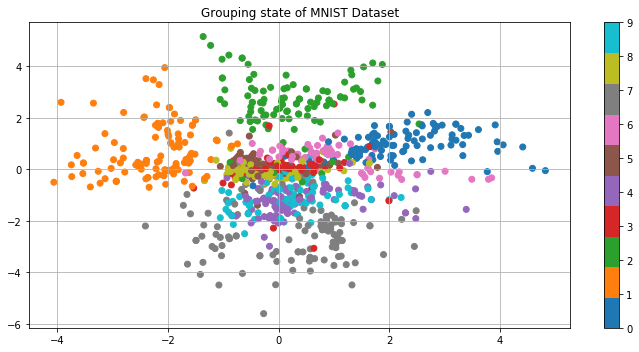

In [72]:
# VAE訓練後，數字辨識的分群狀態
fig, ax = plt.subplots(figsize=(10,5))
ax.set(  title = 'Grouping state of MNIST Dataset')
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab10')
plt.colorbar()
plt.grid()
plt.tight_layout()
plt.show()

### VAE Decoder 的視覺化呈現

In [20]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [21]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

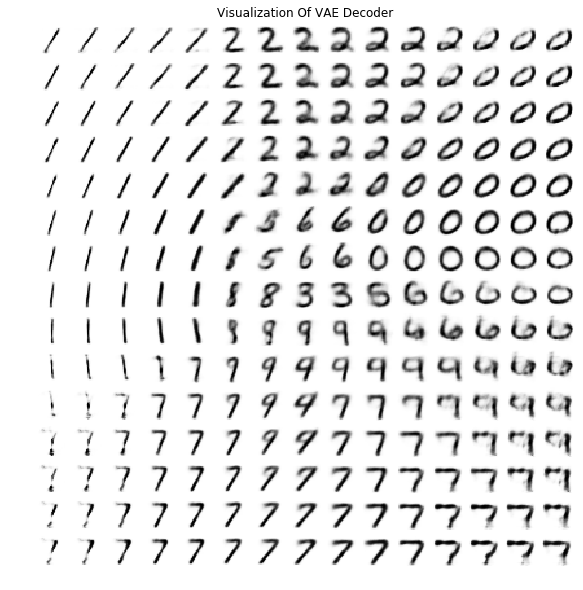

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(title = 'Visualization Of VAE Decoder')
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

### 使用Interact看看抽出來的數字變化

In [26]:
from ipywidgets import interact, FloatSlider

In [54]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='hot')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='copper')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='YlOrBr')

In [57]:
idx_1, idx_2= np.random.randint(10000,size=2)

In [60]:
interact(inBetween,t = FloatSlider(value=0.5,min=0,max=1.0,step=0.1))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.inBetween(t)>

![ex_screenshot](cp.PNG)